This is the continuation of last weeks exercise.
After having analysed the Titanic Dataset, you should now prepare a machine
learning model to predict whether passengers will survive.

It is entirely up to you which algorithm and feature engineering to use.
I do recommend using some of the algorithms available in sklearn, but if you would 
like to use another library that's also ok. It's a good idea to try and evaluate different algorithms,
and different pre-processing/cleaning/feature-generation options if you have the time.
I have split the training data into a train- and a test-set already. These can be found as separate files 
in the `data`-directory. You should only use the training set throughout your entire development -- feel free 
to use cross-validation or split the training set into a train- and a validation set again.
Once you have developed a final model, you should evaluate this model on the test set I've provided,
and report the MCC score for the test set in the title of your PR. You should **not** evaluate the test
set more than once for this initial submission!

If you decide to change your code after code-review, you can report new values in the comments, but
leave the initial MCC in the title unchanged.

In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from sklearn import tree, datasets, cluster, manifold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import train_test_split


test_df = pd.read_csv("titanic_test.csv")
train_df = pd.read_csv("titanic_train.csv")

train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,565,0,3,"Meanwell, Miss. (Marion Ogden)",female,NaN,0,0,SOTON/O.Q. 392087,8.0500,NaN,S
1,858,1,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S
2,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
3,612,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S
4,67,1,2,"Nye, Mrs. (Elizabeth Ramell)",female,29.0,0,0,C.A. 29395,10.5000,F33,S
...,...,...,...,...,...,...,...,...,...,...,...,...
752,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S
753,254,0,3,"Lobb, Mr. William Arthur",male,30.0,1,0,A/5. 3336,16.1000,NaN,S
754,642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C
755,480,1,3,"Hirvonen, Miss. Hildur E",female,2.0,0,1,3101298,12.2875,NaN,S


In [161]:
train_df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,565,0,3,"Meanwell, Miss. (Marion Ogden)",female,NaN,0,0,SOTON/O.Q. 392087,8.0500,NaN,S
1,858,1,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S
2,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
3,612,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S
4,67,1,2,"Nye, Mrs. (Elizabeth Ramell)",female,29.0,0,0,C.A. 29395,10.5000,F33,S
5,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S
6,724,0,2,"Hodges, Mr. Henry Price",male,50.0,0,0,250643,13.0000,NaN,S
7,770,0,3,"Gronnestad, Mr. Daniel Danielsen",male,32.0,0,0,8471,8.3625,NaN,S


Removing PassengerID, Cabin, Ticket, Name and Embarked as it is not relevant at all.

In [162]:
train_df = train_df.drop(["PassengerId", "Cabin", "Ticket", "Name", "Embarked"], axis=1)

Turning male and female to 0 and 1

In [163]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,NaN,0,0,8.0500
1,1,1,0,51.0,0,0,26.5500
2,1,3,1,NaN,1,1,22.3583
3,0,3,0,NaN,0,0,7.0500
4,1,2,1,29.0,0,0,10.5000
...,...,...,...,...,...,...,...
752,0,1,0,NaN,0,0,0.0000
753,0,3,0,30.0,1,0,16.1000
754,1,1,1,24.0,0,0,69.3000
755,1,3,1,2.0,0,1,12.2875


Handle the ages missing values

In [164]:
train_df.fillna({"Age": train_df["Age"].mean()})

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,29.567002,0,0,8.0500
1,1,1,0,51.000000,0,0,26.5500
2,1,3,1,29.567002,1,1,22.3583
3,0,3,0,29.567002,0,0,7.0500
4,1,2,1,29.000000,0,0,10.5000
...,...,...,...,...,...,...,...
752,0,1,0,29.567002,0,0,0.0000
753,0,3,0,30.000000,1,0,16.1000
754,1,1,1,24.000000,0,0,69.3000
755,1,3,1,2.000000,0,1,12.2875


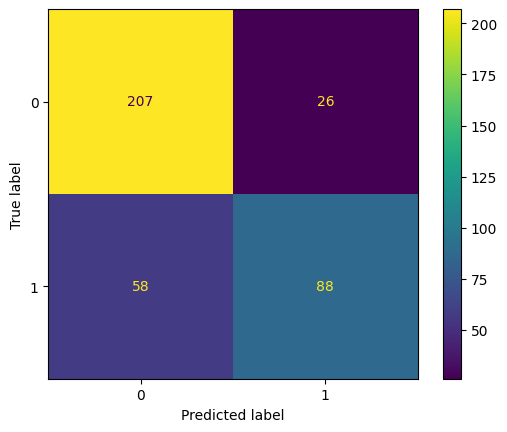

In [165]:
x = train_df.iloc[:, 1:]
y = train_df[["Survived"]]
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.5, stratify=y)

classifier = tree.DecisionTreeClassifier(max_depth=18)
classifier.fit(x_train,y_train)
ConfusionMatrixDisplay.from_estimator(classifier, x_val, y_val)

Building a decision tree

In [166]:
final_classifier = tree.DecisionTreeClassifier(max_depth=18)
final_classifier.fit(x,y)

matthews_corrcoef(y_train, final_classifier.predict(x_train))

0.8091372526459417

Now doing everything with the test file

In [167]:
test_df = test_df.drop(["PassengerId", "Cabin", "Ticket", "Name", "Embarked"], axis=1)
test_df.fillna({"Age": test_df["Age"].mean()})

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,3,0,25.000000,0,0,0.0000
1,0,3,0,26.000000,1,0,7.8542
2,0,3,0,17.000000,0,0,7.1250
3,0,3,1,30.448598,8,2,69.5500
4,0,3,0,30.448598,0,0,7.8958
...,...,...,...,...,...,...,...
129,0,2,0,18.000000,0,0,73.5000
130,0,1,0,40.000000,0,0,0.0000
131,0,2,0,36.500000,0,2,26.0000
132,1,2,1,19.000000,1,0,26.0000


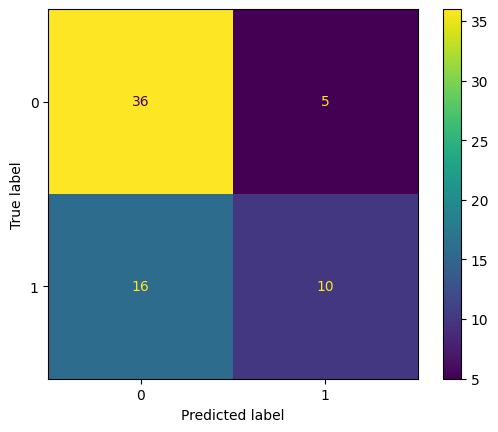

In [168]:
x = test_df.iloc[:, 1:]
y = test_df[["Survived"]]
x_test, x_val, y_test, y_val = train_test_split(x,y, test_size=0.5, stratify=y)

classifier = tree.DecisionTreeClassifier(max_depth=18)
classifier.fit(x_test,y_test)
ConfusionMatrixDisplay.from_estimator(classifier, x_val, y_val)

In [169]:
final_classifier = tree.DecisionTreeClassifier(max_depth=18)
final_classifier.fit(x,y)

matthews_corrcoef(y_test, final_classifier.predict(x_test))

0.8721170677930837